In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data

# load data
users,ratings,movies = load_data('../../data/ml-1m/')

## Nans

In [4]:
print("Nans in users")
print(users.isna().sum(), "\n")


print("Nans in ratings")
print(ratings.isna().sum(), "\n")

print("Nans in movies")
print(movies.isna().sum(),  "\n")

Nans in users
user_id       0
gender        0
age           0
occupation    0
zip           0
dtype: int64 

Nans in ratings
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64 

Nans in movies
movie_id    0
title       0
genres      0
dtype: int64 



## Duplicates

In [5]:
print("Duplicated in users")
print(users.duplicated().sum(), "\n")


print("Duplicated in ratings")
print(ratings.duplicated().sum(), "\n")

print("Duplicated in movies")
print(movies.duplicated().sum(),  "\n")

Duplicated in users
0 

Duplicated in ratings
0 

Duplicated in movies
0 



We already can see that there is no duplicates and no nans in the data which is great because we don't have to care that much about it now.

## Get to know more about movies

/tmp/ipykernel_455217/1338655268.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


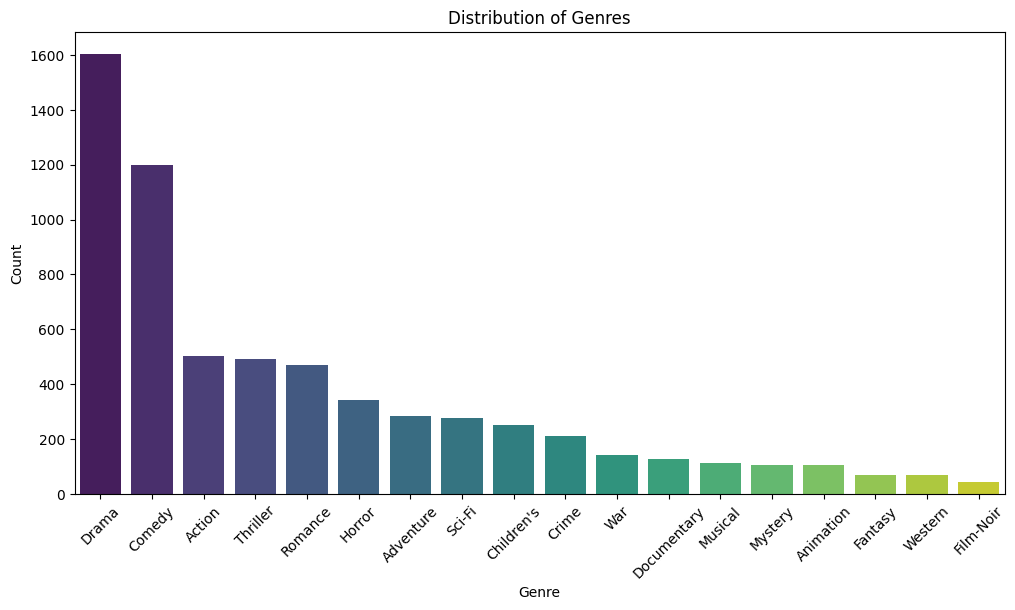

/tmp/ipykernel_455217/1338655268.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(movies['year'], bins=range(movies['year'].min(), movies['year'].max() + 1), kde=False, palette='viridis')


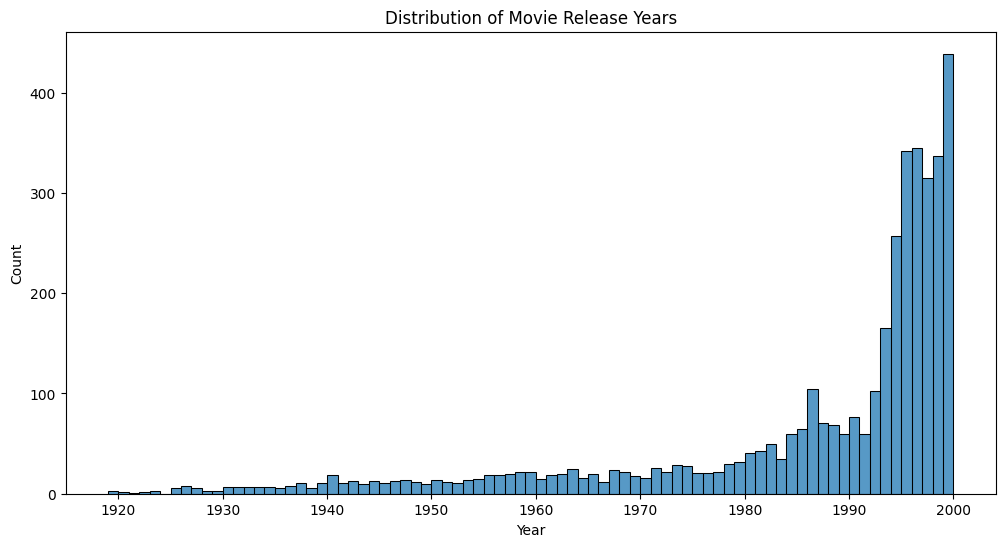

In [6]:
# Preprocess genres
genre_list = movies['genres'].str.split('|').explode()
genre_counts = genre_list.value_counts()

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(int)
year_counts = movies['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(movies['year'], bins=range(movies['year'].min(), movies['year'].max() + 1), kde=False, palette='viridis')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

From the plots above we see that the most popular movies are the movies that are either drama or comedy, other movies are much less popular. 
Ganres starting from War and ending with Film-Noir are very not popular, this could help us to build baseline model, because we will know that which ganre we should give a favour.

Another plot shows us distrubution of films by year, as we can see the dominant share of the movies was released in 1990-2000 and it makes sense, because we have more movies from that period and more views, therefore more ratings.

In [7]:
df_rating_movie = pd.merge(ratings,movies,how='left',on='movie_id')

# Calculate average rating per year
avg_rating_per_year = df_rating_movie.groupby('year')['rating'].mean().reset_index()
# Preprocess genres
df_genres = df_rating_movie[['rating', 'genres']].copy()
df_genres['genres'] = df_genres['genres'].str.split('|')
df_genres = df_genres.explode('genres')

# Calculate average rating per genre
avg_rating_per_genre = df_genres.groupby('genres')['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='rating', data=avg_rating_per_year, marker='o', palette='viridis')
plt.title('Average Rating per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='genres', data=avg_rating_per_genre.sort_values(by='rating'), palette='viridis')
plt.title('Average Rating per Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

SyntaxError: invalid syntax (1950989786.py, line 4)

Another one important aspect is the ratings, we can see that there is negative trend for average rating starting from 1970 and up to 2000, which might tell us that over time, users may have become more critical in their ratings, reflecting a shift towards more discerning or critical viewing habits. But this is not very likely, because we did not collect data from 1930, more likely is that different categories of users whatched movies from 1930-1970 and 1970-2000, and these groups have different evaluations. 

Another important thing is average rating per genre, even though film-noir/documentary/war/crime is one of the least popular ganres in has the highest mean rating, that is another evidence that we might have different groups that rated this films.

Overall drama seems the safest option, because users watch it a lot and it has high meant rating.

In [8]:
# We can see that older users tend to give higher ratings
pd.merge(ratings,users,how='left',on='user_id').groupby('age')['rating'].mean()

age
1     3.549520
18    3.507573
25    3.545235
35    3.618162
45    3.638062
50    3.714512
56    3.766632
Name: rating, dtype: float64

We can see that indeed elder people, that probably mostly watched movies from 1920-1950, give higher mean rating, which pretty much explains why new movies have smaller rating on average.

In [10]:
pd.merge(ratings,users,how='left',on='user_id').groupby('gender')['rating'].mean()

gender
F    3.620366
M    3.568879
Name: rating, dtype: float64

We also observe that there is small difference between female and male ratings, but we do not think that it is too big to take into accout on initial stages.

Text(0, 0.5, 'Frequency')

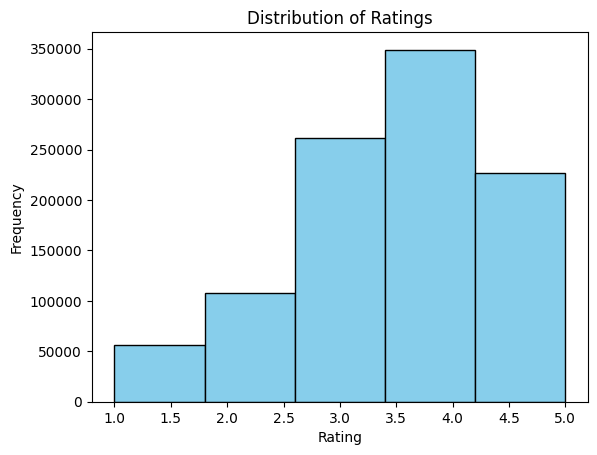

In [11]:
ratings['rating'].hist(bins=5, grid=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')


From the distribution of ratings we spot that mostly ratings are positive (higher than 3), but does it mean that users like movies that watch? Probably the answer is no, it is very likely that users rarely rate movies that they don't like, because they simply skip them, they start watching it and just decide to not continue. 

Therefore, tt would be very beneficial for us to have information about user watch history, which movies he started to whatch and skipped, for instance. It would provide more insights and more data for us to build better models on.

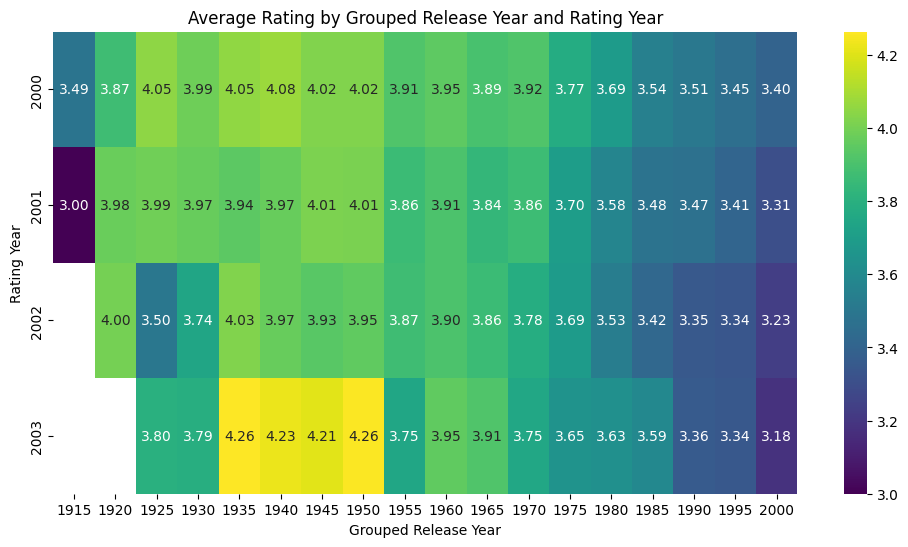

In [12]:
merged_df = pd.merge(ratings, movies, on='movie_id')

# Extract release year from title
merged_df['release_year'] = merged_df['title'].str.extract(r'\((\d{4})\)').astype(int)

# Convert timestamp to year
merged_df['rating_year'] = pd.to_datetime(merged_df['timestamp'], unit='s').dt.year

# Group release years into 5-year intervals
merged_df['release_year_group'] = (merged_df['release_year'] // 5) * 5

# Calculate average rating for each combination of grouped release year and rating year
avg_rating_df = merged_df.groupby(['release_year_group', 'rating_year'])['rating'].mean().reset_index()

# Pivot the DataFrame to a format suitable for a heatmap
pivot_table = avg_rating_df.pivot(index='rating_year', columns='release_year_group', values='rating')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')
plt.title('Average Rating by Grouped Release Year and Rating Year')
plt.xlabel('Grouped Release Year')
plt.ylabel('Rating Year')
plt.show()

Her is a few points which we can see on this plot: 

1. Users in 2003 showed a strong preference for classic movies from the 1940s, which could suggest a trend or nostalgia for older films during that period.
2. We might have some temporal bias in ratings. The data indicates potential temporal biases, where the perceived quality of movies changes based on the time they are rated. This is evident in the lower ratings for older movies in 2001 compared to other years. Maybe this is expected behaviour, but still this is a thing on which we need to keep an eye on.
3. The 1940s stand out as a decade with consistently high ratings across multiple years, possibly indicating a golden age of cinema appreciated by viewers in the early 2000s.

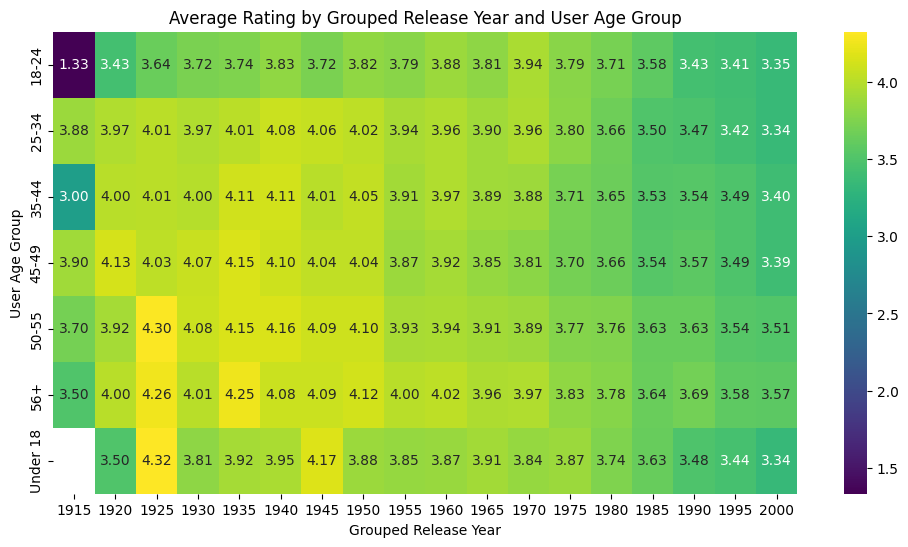

In [13]:
age_groups = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

# Merge ratings and movies on movie_id
merged_df = pd.merge(ratings, movies, on='movie_id')

# Merge the result with users on user_id
merged_df = pd.merge(merged_df, users, on='user_id')

# Extract release year from title
merged_df['release_year'] = merged_df['title'].str.extract(r'\((\d{4})\)').astype(int)

# Convert timestamp to year
merged_df['rating_year'] = pd.to_datetime(merged_df['timestamp'], unit='s').dt.year

# Group release years into 5-year intervals
merged_df['release_year_group'] = (merged_df['release_year'] // 5) * 5

# Map age codes to age groups
merged_df['age_group'] = merged_df['age'].map(age_groups)

# Calculate average rating for each combination of grouped release year and user age group
avg_rating_df = merged_df.groupby(['release_year_group', 'age_group'])['rating'].mean().reset_index()

# Pivot the DataFrame to a format suitable for a heatmap
pivot_table = avg_rating_df.pivot(index='age_group', columns='release_year_group', values='rating')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')
plt.title('Average Rating by Grouped Release Year and User Age Group')
plt.xlabel('Grouped Release Year')
plt.ylabel('User Age Group')
plt.show()

Viewers aged 25-56+ favor classic movies from the 1920-1950, often rating them above 4.0, reflecting nostalgia or appreciation for older films. Conversely, those aged 18-24 show minimal interest in very old films, rating them much lower.

The under 18 age group shows high appreciation for films from the 1925s and 1945s, with ratings around 4.32. This is unusual and might be influenced by a smaller sample size or specific tastes within this group.

Overall this plot either says that most users like films from 1925-1970 mostly, or that the data is inconsistent (we have weird 1.33 avg rating for 1915s films for users aged 18-24, we have high positive bias towards movies released in 1925-1970 for most of the users).


